<a href="https://colab.research.google.com/github/ShrimanthAM/DeepLearningClass/blob/master/DATA690_Fall2020_HW3_Shrimanth_Ajjamane_Manohar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises, Due October 19th (thats 3 weeks!) 

1. Modify  `LanguageNameDataset` the so that the `vocabulary` object in the constructor does not need to be passed in as an argument, but instead can be _inferred_ from the input dataset. This means you will need to iterate through the dataset, and create a dictionary with all of the characters _actually seen_. One way to implement this is to create a default value  `vocabulary=None`, and use `is vocabulary None:` to change behavior. 


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/MPDL Fall 2020/')

from mpdl import train_simple_network

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from mpdl import train_simple_network, Flatten, weight_reset

Mounted at /content/gdrive/


In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [3]:
torch.backends.cudnn.deterministic=True
from mpdl import set_seed, moveTo
set_seed(42)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

###Q1. 
###Modify  `LanguageNameDataset` the so that the `vocabulary` object in the constructor does not need to be passed in as an argument, but instead can be _inferred_ from the input dataset. This means you will need to iterate through the dataset, and create a dictionary with all of the characters _actually seen_. One way to implement this is to create a default value  `vocabulary=None`, and use `is vocabulary None:` to change behavior.

In [5]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

In [8]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [10]:
len(all_letters)

57

In [ ]:
namge_language_data

In [ ]:
type(all_letters)

str

In [ ]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [ ]:
namge_language_data.values()

dict_values([['khoury', 'nahas', 'daher', 'gerges', 'nazari', 'maalouf', 'gerges', 'naifeh', 'guirguis', 'baba', 'sabbagh', 'attia', 'tahan', 'haddad', 'aswad', 'najjar', 'dagher', 'maloof', 'isa', 'asghar', 'nader', 'gaber', 'abboud', 'maalouf', 'zogby', 'srour', 'bahar', 'mustafa', 'hanania', 'daher', 'tuma', 'nahas', 'saliba', 'shamoon', 'handal', 'baba', 'amari', 'bahar', 'atiyeh', 'said', 'khouri', 'tahan', 'baba', 'mustafa', 'guirguis', 'sleiman', 'seif', 'dagher', 'bahar', 'gaber', 'harb', 'seif', 'asker', 'nader', 'antar', 'awad', 'srour', 'shadid', 'hajjar', 'hanania', 'kalb', 'shadid', 'bazzi', 'mustafa', 'masih', 'ghanem', 'haddad', 'isa', 'antoun', 'sarraf', 'sleiman', 'dagher', 'najjar', 'malouf', 'nahas', 'naser', 'saliba', 'shamon', 'malouf', 'kalb', 'daher', 'maalouf', 'wasem', 'kanaan', 'naifeh', 'boutros', 'moghadam', 'masih', 'sleiman', 'aswad', 'cham', 'assaf', 'quraishi', 'shalhoub', 'sabbag', 'mifsud', 'gaber', 'shammas', 'tannous', 'sleiman', 'bazzi', 'quraishi',

In [12]:
namge_language_data.values()

dict_values([['khoury', 'nahas', 'daher', 'gerges', 'nazari', 'maalouf', 'gerges', 'naifeh', 'guirguis', 'baba', 'sabbagh', 'attia', 'tahan', 'haddad', 'aswad', 'najjar', 'dagher', 'maloof', 'isa', 'asghar', 'nader', 'gaber', 'abboud', 'maalouf', 'zogby', 'srour', 'bahar', 'mustafa', 'hanania', 'daher', 'tuma', 'nahas', 'saliba', 'shamoon', 'handal', 'baba', 'amari', 'bahar', 'atiyeh', 'said', 'khouri', 'tahan', 'baba', 'mustafa', 'guirguis', 'sleiman', 'seif', 'dagher', 'bahar', 'gaber', 'harb', 'seif', 'asker', 'nader', 'antar', 'awad', 'srour', 'shadid', 'hajjar', 'hanania', 'kalb', 'shadid', 'bazzi', 'mustafa', 'masih', 'ghanem', 'haddad', 'isa', 'antoun', 'sarraf', 'sleiman', 'dagher', 'najjar', 'malouf', 'nahas', 'naser', 'saliba', 'shamon', 'malouf', 'kalb', 'daher', 'maalouf', 'wasem', 'kanaan', 'naifeh', 'boutros', 'moghadam', 'masih', 'sleiman', 'aswad', 'cham', 'assaf', 'quraishi', 'shalhoub', 'sabbag', 'mifsud', 'gaber', 'shammas', 'tannous', 'sleiman', 'bazzi', 'quraishi',

In [ ]:
a=list(res)

In [ ]:
res1 = list(''.join(a))

TypeError: ignored

In [ ]:
for word in namge_language_data.values():
  #char_list=list(word)
  print(word)

['khoury', 'nahas', 'daher', 'gerges', 'nazari', 'maalouf', 'gerges', 'naifeh', 'guirguis', 'baba', 'sabbagh', 'attia', 'tahan', 'haddad', 'aswad', 'najjar', 'dagher', 'maloof', 'isa', 'asghar', 'nader', 'gaber', 'abboud', 'maalouf', 'zogby', 'srour', 'bahar', 'mustafa', 'hanania', 'daher', 'tuma', 'nahas', 'saliba', 'shamoon', 'handal', 'baba', 'amari', 'bahar', 'atiyeh', 'said', 'khouri', 'tahan', 'baba', 'mustafa', 'guirguis', 'sleiman', 'seif', 'dagher', 'bahar', 'gaber', 'harb', 'seif', 'asker', 'nader', 'antar', 'awad', 'srour', 'shadid', 'hajjar', 'hanania', 'kalb', 'shadid', 'bazzi', 'mustafa', 'masih', 'ghanem', 'haddad', 'isa', 'antoun', 'sarraf', 'sleiman', 'dagher', 'najjar', 'malouf', 'nahas', 'naser', 'saliba', 'shamon', 'malouf', 'kalb', 'daher', 'maalouf', 'wasem', 'kanaan', 'naifeh', 'boutros', 'moghadam', 'masih', 'sleiman', 'aswad', 'cham', 'assaf', 'quraishi', 'shalhoub', 'sabbag', 'mifsud', 'gaber', 'shammas', 'tannous', 'sleiman', 'bazzi', 'quraishi', 'rahal', 'ch

In [ ]:
x_list

'Vietnamese'

In [ ]:
word = "Arabicc"
list_of_letters = list(word)
x= list_of_letters

In [ ]:
a_set = {0, 1, 2}

list_of_strings = [str(s) for s in a_set]
joined_string = " ".join(list_of_strings)

print(joined_string)

0 1 2


In [ ]:
type(joined_string)

str

In [ ]:
x

['A', 'r', 'a', 'b', 'i', 'c', 'c']

In [ ]:
#y=set(x)

set

In [ ]:
z=list(y)

['a', 'A', 'r', 'c', 'i', 'b']

In [ ]:
lang_names

In [ ]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        # label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

In [ ]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

In [ ]:
dataset.labels

In [ ]:
train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
train_data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
sss = StratifiedShuffleSplit(n_splits = 18, test_size = 0.3, random_state=42)
sss.get_n_splits(dataset)

18

In [ ]:
sss = StratifiedShuffleSplit(n_splits= 18, test_size=0.3, random_state=42)

In [ ]:
for train_index, test_index in sss.split(dataset,dataset.labels):
    print('Train:', train_index, 'Test:', test_index)
    train_set2 = dataset.loc[train_index]
    test_set2 = dataset.loc[test_index]

Train: [ 8091 17867  9988 ...  9297 13638 13107] Test: [ 9972 16790  6768 ...  7882 16278 12393]


AttributeError: ignored

### Q2. 
### Update the `LanguageNameDataset` with a flag in the constructor for `unicode=False`. You should change any of the code you need to so that when `unicode=True`, the `LanguageNameDataset` will instead keep all the unicode characters seen when `vocabulary=None` (this depends on question 1). Train a new RNN classifier with `unicode=True`, how does it impact the results?


### Q3. 
#### The original training/test split for this task was created by randomly sampling the dataset. Create your own function that performs _stratified_ splitting. This means it will select a test set that has the exact same proportions of each class. How does this impact your apparent results?

### Q4. 
### Replace the last output layer `nn.Linear(hidden_nodes, classes)` from the RNN implementation with a fully-connected network with 2 hidden layers and one output layer. How does this impact the accuracy of the model?

In [13]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

In [14]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [15]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        # label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

In [25]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [17]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple, 
            last_step = last_step[0]#then h_t is the first item in the tuple
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate 
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [18]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here!
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, 15),
  nn.Linear(15, 15),
  nn.Linear(15, classes), #(B, D) -> (B, classes)
)

In [19]:
loss_func = nn.CrossEntropyLoss()
batch_one_train = train_simple_network(first_rnn, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5)

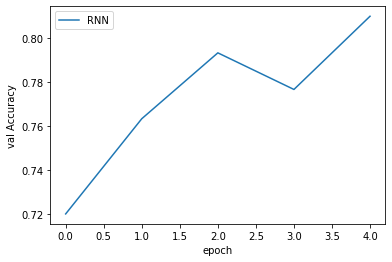

In [20]:
sns.lineplot(x='epoch', y='val Accuracy', data=batch_one_train, label='RNN')

### Q5. 
### Compare training a 3-layer bidirectional RNN with batch sizes of $B=\{1, 2, 4, 8\}$ for 5 epochs. Which batch size seems to give the best balance between speed and accuracy? 

In [26]:
def pad_and_pack(batch):
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched


In [27]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.to(input.data.device), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)


In [28]:
B = 1
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

In [29]:
rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)

Sequential(
  (0): EmbeddingPackable(
    (embd_layer): Embedding(57, 64)
  )
  (1): RNN(64, 256, num_layers=3, batch_first=True, bidirectional=True)
  (2): LastTimeStep()
  (3): Linear(in_features=512, out_features=18, bias=True)
)

In [ ]:
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, loss_func, train_loader, val_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=5, lr=0.01)